# Gissinger Dataset
This notebook containes functions for analyzing the Gissinger system and generating Gissinger datasets.
### Gissinger system
The dynamics of the Gissinger system is definded by the following set of differential equations:
$$
\dot{Q} = \mu Q - VD
$$

$$
\dot{D} = -\nu D + VQ
$$
$$
\dot{V} = \Gamma - V + QD 
$$
The system was originally defined in the following paper: https://arxiv.org/abs/1109.6569, there the author proves that a the system can becom chaotic for certain values of the parameters $(\mu,\nu,\Gamma) = (0.119,0.1,0.9)$.<br>
Those parameters are used to generate a series of trajectories. The trajectories are obtained by integrating a set of randomly sapled initial conditions. Two types of trajectories are considered corresponding to the training and validation datasets. The traing set contains more elements but its trajectories are integrated in for shorter times, while the validation set contains considerably less trajectories, but with longer integration times.


In [124]:
import numpy as np
import numpy.linalg as lin
from scipy.integrate import odeint
from scipy.optimize import fsolve
import h5py
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [125]:
def gissinger(state,t,mu=0.119,nu=0.1,gamma=0.9):
    """
    Differential equation defining the gissinger
    system - passed to odeint
    Args:
    state: (Q,D,V) dynamic variables of the system
    t: time variable
    parameters:
    mu,nu,gamma
    Returns:
    derivateives of Q,D and V in time.
    """
    Q = state[0]
    D=state[1]
    V =state[2]
    dQ = mu*Q - V*D
    dD = -nu*D + V*Q
    dV = gamma - V + Q*D
    return np.array([dQ,dD,dV])
    

def plot_trajectories(
    initial = None,n_traj:int = 4,
    params:dict = {},t:np.array = None,
    noise_std:float = 0.1):
    """
    The function generates n_traj trajectories
    that start with 'close' initail conditions.
    It is used to vizualize the trajectory divergence
    in time.
    Args:
    initial: array containing the initial conditions.
    n_traj: int, number of trajectories to visualize.
    params: dictionary containing the values of mu, nu and gamma.
    t: time array to integrate the trajectories.
    noise_std: standard deviation for the noise pertubation of initial conditions
    Returns: fig: 3d plot of the system
    """

    if initial is None:
        initial = np.array([-1,0,-1])
    else:
        initial = np.array(initial)
    if t is None:
        t = np.arange(0,15,1e-3)
    if not params:
        mu = 0.119
        nu = 0.1
        gamma = 0.9
    else:
        mu = params["mu"]
        nu = params["nu"]
        gamma = params["gamma"]

    snorm = np.sqrt(np.linalg.norm(initial))

    frame,fig = plt.subplots(figsize=(5,5),subplot_kw = {"projection": "3d"})
    sol = odeint(gissinger,initial,t)
    #fig.plot(sol[:,0],sol[:,1],sol[:,2],label = "initial = ({:.3f},{:.3f},{:.3f})".format(
    #    initial[0],initial[1],initial[2]))
    #fig.scatter(sol[0,0],sol[0,1],sol[0,2])
    
    for traj in range(n_traj):
        init = np.random.uniform(low=-2,high= 2,size = 3)#np.random.randn(3)*noise_std
        sol = odeint(gissinger,init,t,args = (mu,nu,gamma,))
        fig.plot(sol[:,0],sol[:,1],sol[:,2],label = "initial = ({:.3f},{:.3f},{:.3f})".format(init[0],init[1],init[2]))
        fig.scatter(sol[0,0],sol[0,1],sol[0,2])
    fig.set_xlabel("Q")
    fig.set_ylabel("D")
    fig.set_zlabel("V")
    fig.legend()
    return fig


def jacobian(Q,D,V,mu=0.119,nu=0.1):
    """
    Calculae the Jacobian of the Gissinger system ODE
    Args:
    Q,D,V: Gissinger state variables
    mu,nu: Gissinger system parameters
    Returns:
    J: 3x3 array of Jacobian
    """
    J = np.zeros([3,3])
    J[0,0]=mu
    J[0,1]=-V
    J[0,2]=-D
    J[1,0]=V
    J[1,1]=-nu
    J[1,2]=Q    
    J[2,0]=D
    J[2,1]=Q
    J[2,2]=-1
    return J



def gissinger_and_variation(state_and_variation,t,mu=0.119,nu=0.1,gamma=0.9):
    """
    Function used to integrate the Gissinger trajectory and
    the corresponding divergence of trajectories
    Args:
    state_and_variation: iterable contiaining 3+3 elements
    The first 3 are the gissinger state variables and the second 3 are the variation states
    t: time step used for integration
    Returns:
    Dstate_and_variation: derivatives of the state_and_variation variables
    """
    state = state_and_variation[:3]
    variation = state_and_variation[3:]
    Dstate_and_variation = np.zeros(6)
    Dstate_and_variation[:3] = gissinger(state,t,mu,nu,gamma)
    J = jacobian(state[0],state[1],state[2],mu,nu)
    Dstate_and_variation[3:] = np.matmul(J,variation)
    return Dstate_and_variation
    


def calc_mean_lyapunov(n_curves=1,Tmax=50,tau = 1):
    """
    Estimating Lyapunov exponents using the procedure described in:
    https://books.google.hr/books/about/Practical_Numerical_Algorithms_for_Chaot.html?id=lHDjBwAAQBAJ&redir_esc=y
    Chapter: 3 page: 74
    """

    initial = np.random.uniform(low=-2,high=2,size=(n_curves,3))
    t = np.arange(0,Tmax,1e-2)
    n_in_tau = int(tau/1e-2)
    indices = [i for i in range(1,len(t),n_in_tau)]  
    ts = np.split(t,indices) 
    lyapunovs=[]
    for i in tqdm(range(n_curves)):
        var0 = np.random.randn(3)
        var0*=1e-2/lin.norm(var0)
        state_and_variations0 = np.concatenate([initial[i,:],var0])
        ds =  []
        for interval in ts:
            state_and_variations = odeint(
            gissinger_and_variation,state_and_variations0,interval
        )

            d = lin.norm(state_and_variations[-1,3:])/lin.norm(state_and_variations[0,3:])
            ds.append(np.log(d)/tau)
            state_and_variations0 = state_and_variations[-1,:]
            state_and_variations0[3:] = 1e-2*state_and_variations0[3:]/lin.norm(state_and_variations0[3:])
        lyapunovs.append(np.mean(ds))
    return np.mean(lyapunovs)




def _func(state,mu=0.119,nu=0.1,gamma=0.9):
    """
    Helper function for calculatiing stabile points
    of the Gissinger system.
    """
    Q= state[0]
    D=state[1]
    V =state[2]
    dQ = mu*Q - V*D
    dD = -nu*D + V*Q
    dV = gamma - V + Q*D
    return np.array([dQ,dD,dV])
    
def get_stabile_points(state):
    """
    Finds stabile point of the Gissinger system
    Args:
    state: Initial guess for Q,D,V
    """
    return fsolve(_func,state)
    


def make_h5_file(
    filename,
    n_trajectories=2048,
    tmax = 3,tstep = 0.01,save_dir = None,to_save = None):
    """
    Saves integrated trajectories in to a hdf5 file. Used for model training and evaluation.
    Args:
    filename: string or path save file
    n_trajectories: int number of trajectories to save
    tmax: float maximum time to integrate trajectories
    tstep: float step in time discretization
    save_dir: string or path to the directory where to save data
    Returns:
    None
    """
    if save_dir is None:
        save_dir = "./"
    if not(".hdf5" in filename):
        filename = filename+".hdf5" 
    if to_save is None:
        to_save = int(tmax/tstep)

    t = np.arange(0,tmax,tstep)
    initial_conditions = np.random.uniform(low = -2.3,high = 2.3,size = (n_trajectories,3))
    with h5py.File(os.path.join(save_dir,filename),"w") as f:
        for i in range(n_trajectories):
            trajcetory = odeint(
                gissinger,initial_conditions[i,:],t)
            f.create_dataset(str(i+1),data = trajcetory[:to_save].copy())


#initial = np.array([1,1,1])
#_,variation = calculate_divergence(initial)

## Brute force calculation of the Gissinger system stabile points

In [110]:
Qs = np.arange(-4,4,0.5)
Ds = np.arange(-4,4,0.5)
Vs = np.arange(-4,4,0.5)
stabile = dict()
for q in Qs:
    for d in Ds:
        for v in Vs:
            stabile["{},{},{}".format(q,d,v)]=get_stabile_points(np.array([q,d,v]))


### Stabile point visualization

Text(0.5, 0, 'V')

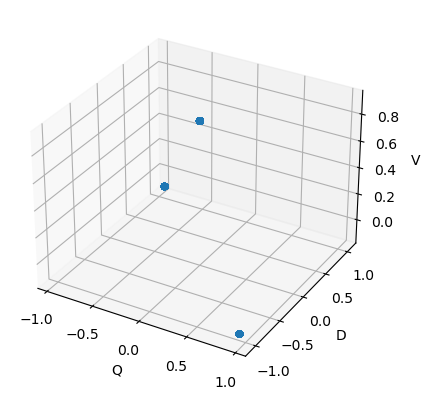

In [112]:
ax = plt.figure().add_subplot(projection = "3d")
X,Y,Z = [],[],[]
for k in stabile.keys():
    X.append(stabile[k][0])
    Y.append(stabile[k][1])
    Z.append(stabile[k][2])

ax.scatter(X,Y,Z)
ax.set_xlabel("Q")
ax.set_ylabel("D")
ax.set_zlabel("V")

## The Chaotic nature of the Gissinger system.
We initialize two nearby points in the phase space and let them evolve in time to show their eventual divergence.  

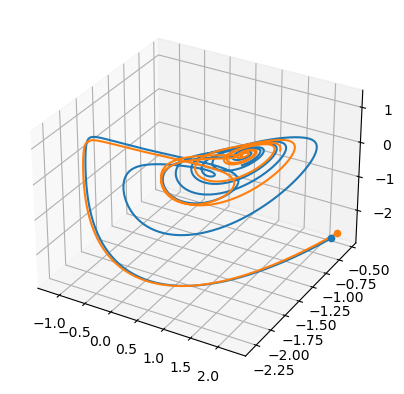

In [78]:
init1 = np.array([2.2,-0.6,-2.7])
delta = np.array([0.05,0.05,0.09])
init2 = init1 + delta
t = np.arange(0,75,1e-2)
sol1 = odeint(gissinger,init1,t)
sol2 = odeint(gissinger,init2,t)
ax = plt.figure().add_subplot(projection = "3d")
ax.scatter(sol1[0,0],sol1[0,1],sol1[0,2])
ax.scatter(sol2[0,0],sol2[0,1],sol2[0,2])
ax.plot(sol1[:,0],sol1[:,1],sol1[:,2])
ax.plot(sol2[:,0],sol2[:,1],sol2[:,2])

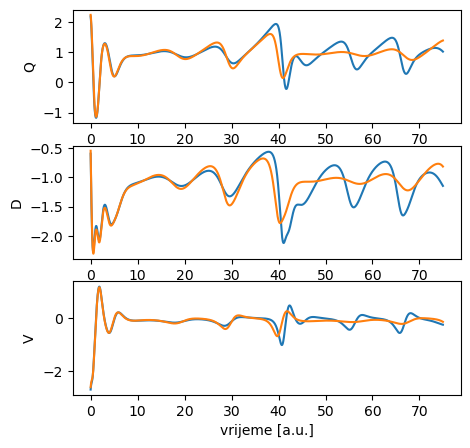

In [74]:
_,fig = plt.subplots(3,1,figsize = (5,5))
variable =["Q","D","V"]
for i in range(3):
    fig[i].plot(t,sol1[:,i])
    fig[i].plot(t,sol2[:,i])
    fig[i].set_ylabel(variable[i])
fig[-1].set_xlabel("vrijeme [a.u.]")

plt.savefig("divergencija_krivulja.png")

## Visualization of the Gissiner attractor
Couple of trajectories are integrated for longer time periods to get an impression of the attractor shape.

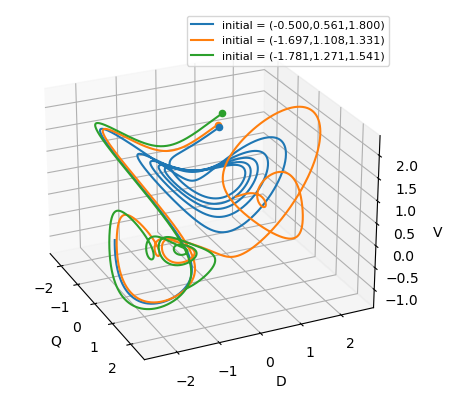

In [90]:
#params = {"mu":0.35,"nu":0.35,"gamma":0.9}
#np.random.seed(112)#112
fig = plot_trajectories(
    n_traj = 3,
    t = np.arange(0,40, 1e-2),#params = params,
    noise_std=1
    )

fig.view_init(elev=25, azim=-25,)
fig.legend(fontsize = 8)
plt.savefig("neke_krivulje.png")

## Mean Lyapunov exponent of the attractor and the horizon time
Here we estimate the mean Lyapunov exponent and the corresponding Lyapunov time which is a characteristic time scale at which the system become chaotic and therefore unpredictable.

In [131]:
ly = calc_mean_lyapunov(n_curves = 150,Tmax = 200,tau = 1)
tau = 1/ly
print(f"Mean Lyapunov exponent: {ly}")
print(f"Mean chaotization time {tau}")

100%|██████████| 150/150 [00:15<00:00,  9.76it/s]

Mean Lyapunov exponent: 0.07464257489747043
Mean chaotization time 13.397179845063048


In [111]:
#make_h5_file("proba",n_trajectories=105,tmax = 3,tstep=0.01,std = 1.)

## Making the training and validation datasets

In [112]:
#make_h5_file("gissinger_training_rk",n_trajectories=2048,tmax = 15,tstep=0.03,std = 1.)
#make_h5_file("gissinger_valid_rk",n_trajectories=64,tmax = 75,tstep=0.03,std = 1.)

## Visualizing training data

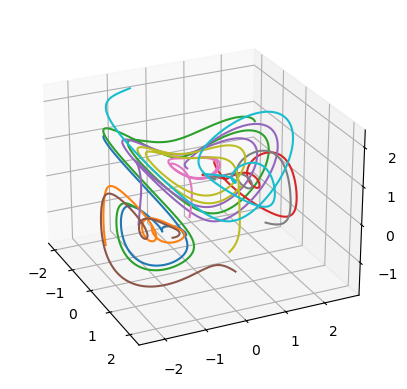

In [120]:
ax = plt.figure().add_subplot(projection = "3d")
with h5py.File("gissinger_training_rk.hdf5","r") as f:
    keys = np.random.choice(list(f.keys()),size = 10)
    for k in keys:
        ax.plot(f[k][:,0],f[k][:,1],f[k][:,2],)

ax.view_init(elev=25, azim=-25,)


### Visualizing validation data

(2500, 3)
(2500, 3)
(2500, 3)
(2500, 3)
(2500, 3)
(2500, 3)
(2500, 3)


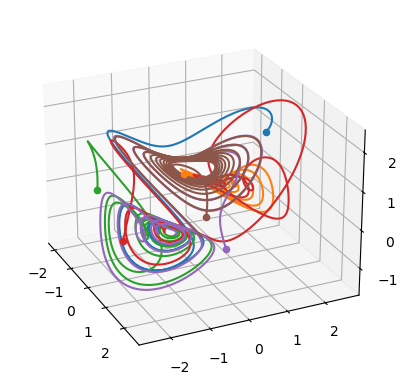

In [121]:
ax = plt.figure().add_subplot(projection = "3d")
with h5py.File("gissinger_valid_rk.hdf5","r") as f:
    print(f["1"].shape)
    keys = np.random.choice(list(f.keys()),size = 6)
    for k in keys:
        ax.plot(f[k][:,0],f[k][:,1],f[k][:,2],)
        ax.scatter(f[k][0,0],f[k][0,1],f[k][0,2])
        #print(f[k].shape)
ax.view_init(elev=25, azim=-25,)

plt.savefig("neke_krivulje.png")